In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import time
import torch
import torch.nn as nn
from torch.nn import functional as F
import numpy as np
import torch.utils.data as Data
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error # 均方误差
from sklearn.metrics import mean_absolute_error # 平方绝对误差
from sklearn.metrics import r2_score # R square

In [4]:
# pip install openpyxl
df = pd.read_csv('./data.csv',skiprows=[1],index_col=0, encoding = 'gbk')
del df['name']
# del df['结算价\n[单位] 元']
# del df['持仓量(商品指数)']
# del df['持仓量变化\n[单位] 手']
# del df['持仓额\n[单位] 元']
# df = df['2005-1-4':]
df.head()

,code,open,high,low,close,volume,turnover,turnover_rate,pos_p(mean),pos_p(median)
date,,,,,,,,,,
2021/10/19,399006,3293.80,3310.02,3273.55,3297.29,97524324,1.980000e+11,2.27,0.346324,0.1364
2021/10/20,399006,3304.55,3320.33,3276.82,3285.12,101313044,2.070000e+11,2.36,0.375009,0.1964
2021/10/21,399006,3286.27,3304.01,3256.85,3279.49,99955587,1.940000e+11,2.33,0.290245,0.0979
2021/10/22,399006,3290.54,3309.56,3268.94,3284.91,102248579,1.990000e+11,2.38,0.324375,0.0768
2021/10/25,399006,3303.22,3342.22,3302.49,3338.62,104409541,2.160000e+11,2.43,0.368120,0.1560


In [5]:
def normalization(data):
    # 归一化
    max_ = np.max(data)
    min_ = np.min(data)
    data = (data - min_) / (max_ - min_)
#     from sklearn.preprocessing import StandardScaler
#     ss = StandardScaler()
#     data = data.values.reshape(-1, 1)
#     data = ss.fit_transform(data)
    return data

def generate_data(df1,df2,df3,df4,data_close):
    # 记录 data 的长度
    n = df1.shape[0]
    # 目标是生成可直接用于训练和测试的 x 和 y
    y = []
    z = []
    #归一化
    df1 = normalization(df1)
    df2 = normalization(df2)
    df3 = normalization(df3)
    df4 = normalization(df4)
    data_close = normalization(data_close)
    # 建立 (5 -> 1) 的 x 和 y
    for i in range(11, n):
        x = []
        x.append(df1[i - 6: i - 1])
        x.append(df2[i - 6: i - 1])
        x.append(df3[i - 6: i - 1])
        x.append(df4[i - 6: i - 1])
        x.append(data_close[i - 6: i - 1])
        y.append(data_close[i - 1])
        z.append(x)

    # 转换为 numpy 数组
    z = np.array(z)
    y = np.array(y)

    return z, y

def compute_mse(y_hat, y):
    y = y.data.cpu().numpy()
    array = np.array(y)-np.array(y_hat.tolist())
    result = 0
    for i in array:
        result += np.square(i)
    return result


def compute_var(y):
    y = y.data.cpu().numpy()
    array = np.array(y)-np.mean(np.array(y))
    result = 0
    for i in array:
        result += np.square(i)
    return result

In [6]:
# 输入的数量是前 5 个交易日的收盘价
# num_inputs = 7
# 输出是下一个交易日的收盘价
# num_outputs = 1
# 隐藏层的个数
# num_hiddens = 128

In [7]:
# # 建立一个稍微复杂的 LSTM 模型
# class LSTM(nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.lstm1 = nn.LSTM(5, num_hiddens, batch_first = True)
#         self.drop = nn.Dropout(0.1)
# #         self.lstm2 = nn.LSTM(num_hiddens, 1, batch_first = True)
#         self.out = nn.Linear(num_hiddens, 1)

#     def forward(self, x):
#         x = x.view(x.shape[0], -1, 5)
#         r_out_1, (h_n_1, h_c_1) = self.lstm1(x, None)
#         relu_1 = F.relu(r_out_1[:, -1, :])  # 只需要最后一个的output
#         drop_1 = self.drop(relu_1)
# #         r_out_2, (h_n_2, h_c_2) = self.lstm2(drop_1, None)
# #         relu_2 = F.relu(r_out_2)
#         out = self.out(drop_1)
#         return out

In [8]:
class CNNLSTMModel_CBAM(nn.Module):

    def __init__(self, window=5, dim=5, lstm_units=16, num_layers=2):
        super(CNNLSTMModel_CBAM, self).__init__()
        self.conv1d = nn.Conv1d(dim, lstm_units, 1)
        self.act1 = nn.Sigmoid()
        self.maxPool = nn.MaxPool1d(kernel_size=window)
        self.drop = nn.Dropout(p=0.01)
        self.lstm = nn.LSTM(lstm_units, lstm_units, batch_first=True, num_layers=2, bidirectional=True)
        self.act2 = nn.Tanh()
        self.cls = nn.Linear(lstm_units * 2, 1)
        self.act4 = nn.Tanh()

        self.se_fc = nn.Linear(window, window)
        self.hw_fc = nn.Linear(lstm_units, lstm_units)

    def forward(self, x):
#         x = x.transpose(-1, -2)  # tf和torch纬度有点不一样
        x = self.conv1d(x)  # in： bs, dim, window out: bs, lstm_units, window
        x = self.act1(x)

        # chanal
        avg = x.mean(dim=1)  # bs, window
        se_attn = self.se_fc(avg).softmax(dim=-1)  # bs, window
        x = torch.einsum("bnd,bd->bnd", x, se_attn)

        # wh
        avg = x.mean(dim=2)  # bs, lstm_units
        hw_attn = self.hw_fc(avg).softmax(dim=-1)  # bs, lstm_units
        x = torch.einsum("bnd,bn->bnd", x, hw_attn)

        x = self.maxPool(x)  # bs, lstm_units, 1
        x = self.drop(x)
        x = x.transpose(-1, -2)  # bs, 1, lstm_units
        x, (_, _) = self.lstm(x)  # bs, 1, 2*lstm_units
        x = self.act2(x)
        x = x.squeeze(dim=1)  # bs, 2*lstm_units
        x = self.cls(x)
        x = self.act4(x)
        return x

In [9]:
# min_ = np.min(df['收盘价\n[单位] 元'])
# max_ = np.max(df['收盘价\n[单位] 元'])
# x, y = generate_data(df['最高价\n[单位] 元'],df['最低价\n[单位] 元'],df['成交量\n[单位] 股(张)'],df['收盘价\n[单位] 元'])
min_ = np.min(df['close'])
max_ = np.max(df['close'])

x, y = generate_data(df['high'],df['low'],df['turnover'],df['pos_p(mean)'],df['close'])
x = torch.tensor(x, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32)
# 将 y 转化形状
# x = torch.squeeze(x)
y = torch.unsqueeze(y, dim=1)
print(x.shape, y.shape)


torch.Size([233, 5, 5]) torch.Size([233, 1])


In [10]:
# 样本总数
num_samples = x.shape[0]
num_train = round(num_samples * 0.8)
num_valid = round(num_samples * 0.1)
num_test = num_samples - num_train - num_valid

In [11]:
train_data = Data.TensorDataset(x[:num_train], y[:num_train])
valid_data = Data.TensorDataset(x[num_train:num_train+num_valid], y[num_train:num_train+num_valid])
test_data = Data.TensorDataset(x[num_train+num_valid:], y[num_train+num_valid:])

batch_size = 64
train_loader = Data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
valid_loader = Data.DataLoader(valid_data, batch_size=batch_size, shuffle=False)
test_loader = Data.DataLoader(test_data, batch_size=batch_size, shuffle=False)

In [12]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# lstm = LSTM().to(device)
lstm = CNNLSTMModel_CBAM().to(device)
loss_fn = nn.MSELoss()
# loss_fn = loss_fn(1)
optimizer = torch.optim.Adam(lstm.parameters(), lr=0.001)

In [13]:
# 用于绘图用的信息
train_losses, valid_losses, train_mses, train_r2s, train_rmses, train_maes, train_mapes, valid_mses, valid_rmses,valid_maes,valid_mapes,valid_r2s = [], [], [], [], [],[],[],[], [], [], [], []

# 循环 num_epochs 次
epochs = 300
for epoch in range(epochs):
    # 初始化参数
    train_mse_sum, train_var_sum , train_mae_sum, train_mape_sum, train_l_sum, n = 0.0, 0.0, 0.0, 0, 0, 0
    # 初始化时间
    start = time.time()

    lstm.train()

    # 对训练数据集的每个 batch 执行
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        y_hat = lstm(x)
        loss = loss_fn(y_hat, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_l_sum += loss.item() * y.shape[0]

        # 计数一共有多少个元素
        n += y.shape[0]
        
        train_mse_sum += compute_mse(y_hat, y) * y.shape[0]
        train_var_sum += compute_var(y) * y.shape[0]
#         train_mae_sum += compute_mae(y_hat, y) * y.shape[0]
#         train_mape_sum += compute_mape(y_hat, y) * y.shape[0]
    train_mse = train_mse_sum/n
    train_var = train_var_sum/n
    train_mae = train_mae_sum/n
    train_mape = train_mape_sum/n
    train_mses.append(train_mse)
    train_rmses.append(np.sqrt(train_mse))
    train_maes.append(train_mae)
    train_mapes.append(train_mape)
    train_r2 = 1 - (train_mse/train_var)
    train_r2s.append(train_r2)

    # 模型开启预测状态
    lstm.eval()

    # 同样的，我们可以计算验证集上的 loss
    valid_mse_sum, valid_var_sum ,valid_mae_sum, valid_mape_sum, valid_l_sum, valid_n = 0.0, 0.0, 0, 0, 0, 0
    for x, y in valid_loader:
        x, y = x.to(device), y.to(device)
        y_hat = lstm(x)
        loss = loss_fn(y_hat, y)
        
        # 对 loss 求和（在下面打印出来）
        valid_l_sum += loss.item() * y.shape[0]

        # 计数一共有多少个元素
        valid_n += y.shape[0]
        
        valid_mse_sum += compute_mse(y_hat, y) * y.shape[0]
        valid_var_sum += compute_var(y) * y.shape[0]
#         valid_mae_sum += compute_mae(y_hat, y) * y.shape[0]
#         valid_mape_sum += compute_mape(y_hat, y) * y.shape[0]
    valid_mse = valid_mse_sum/valid_n
    valid_var = valid_var_sum/valid_n
    valid_mae = valid_mae_sum/valid_n
    valid_mape = valid_mape_sum/valid_n
    valid_mses.append(valid_mse)
    valid_rmses.append(np.sqrt(valid_mse))
    valid_maes.append(valid_mae)
    valid_mapes.append(valid_mape)
    valid_r2 = 1 - (valid_mse/valid_var)
    valid_r2s.append(valid_r2)

    if (epoch + 1) % 10 == 0:
        print(
            'epoch %d, train loss %.6f, valid loss %.6f, train mse %.6f, r2 %.6f, valid mse %.6f,r2 %.6f, time %.2f sec'
            % (epoch + 1, train_l_sum / n, valid_l_sum / valid_n, train_mse, train_r2, valid_mse, valid_r2,
               time.time() - start))

    # 记录绘图有关的信息
    train_losses.append(train_l_sum / n)
    valid_losses.append(valid_l_sum / valid_n)

epoch 10, train loss 0.194594, valid loss 0.042104, train mse 12.053136, r2 -1.495773, valid mse 0.968384,r2 -10.991100, time 0.03 sec
epoch 20, train loss 0.098062, valid loss 0.003565, train mse 6.092475, r2 -0.283101, valid mse 0.081996,r2 -0.015323, time 0.03 sec
epoch 30, train loss 0.077878, valid loss 0.024063, train mse 4.826341, r2 0.000996, valid mse 0.553438,r2 -5.852994, time 0.02 sec
epoch 40, train loss 0.077426, valid loss 0.022042, train mse 4.833795, r2 0.000536, valid mse 0.506976,r2 -5.277677, time 0.02 sec
epoch 50, train loss 0.076720, valid loss 0.021522, train mse 4.776972, r2 -0.002574, valid mse 0.495016,r2 -5.129583, time 0.03 sec
epoch 60, train loss 0.075601, valid loss 0.021626, train mse 4.692954, r2 0.013477, valid mse 0.497388,r2 -5.158950, time 0.04 sec
epoch 70, train loss 0.073663, valid loss 0.022001, train mse 4.584027, r2 0.042011, valid mse 0.506015,r2 -5.265772, time 0.03 sec
epoch 80, train loss 0.071052, valid loss 0.022027, train mse 4.425128,

In [14]:
torch.save(lstm, 'net.pkl')  # 保存整个网络

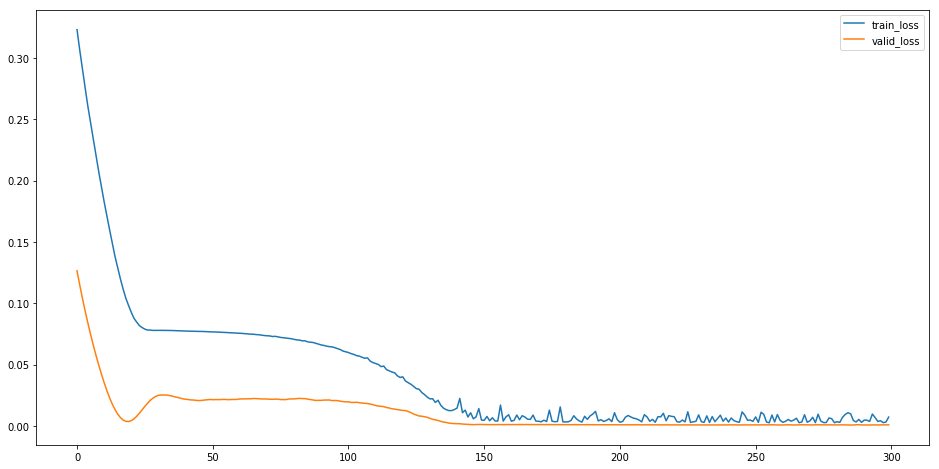

In [15]:
# 新建一个图像
plt.figure(figsize=(16,8))

# 绘制 train_loss 曲线
plt.plot(train_losses[:], label='train_loss')

# 绘制 valid_loss 曲线
plt.plot(valid_losses, label='valid_loss')

# 展示带标签的图像
plt.legend()

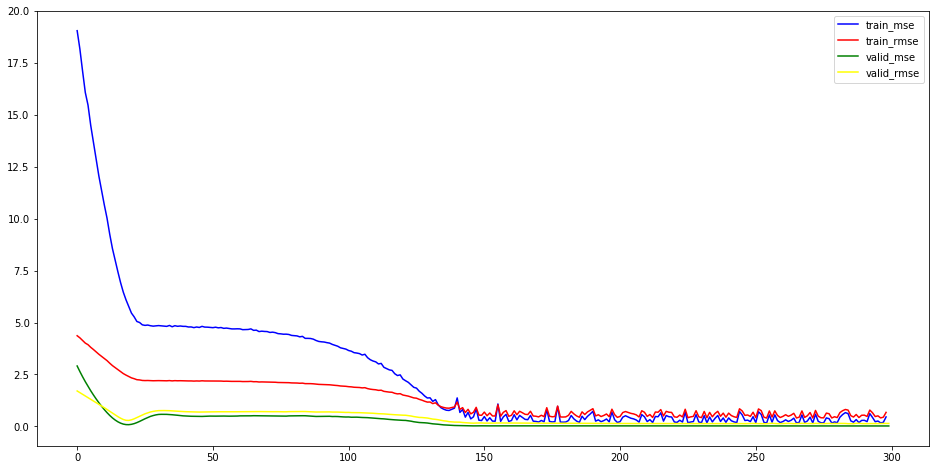

In [16]:
# 新建一个图像
plt.figure(figsize=(16,8))

# 绘画结点
plt.plot(train_mses[1:], c='blue', label='train_mse')

plt.plot(train_rmses[1:], c='red', label='train_rmse')

plt.plot(valid_mses, c='green', label='valid_mse')

plt.plot(valid_rmses[:], c='yellow', label='valid_rmse')

# 展示图像
plt.legend()

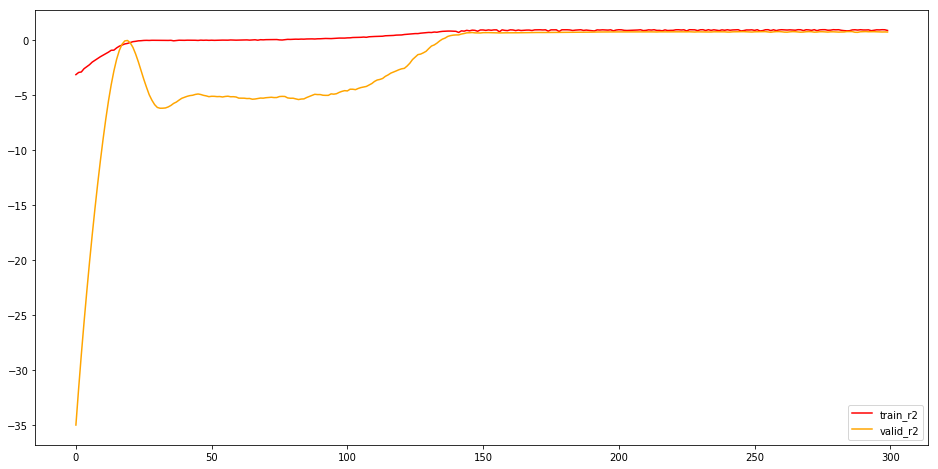

In [17]:
# 新建一个图像
plt.figure(figsize=(16,8))

plt.plot(train_r2s, c='red', label='train_r2')

plt.plot(valid_r2s, c='orange', label='valid_r2')

# 展示图像
plt.legend()

4148.590815912664
64.40955531528427
54.93119366068394
0.522722477267622


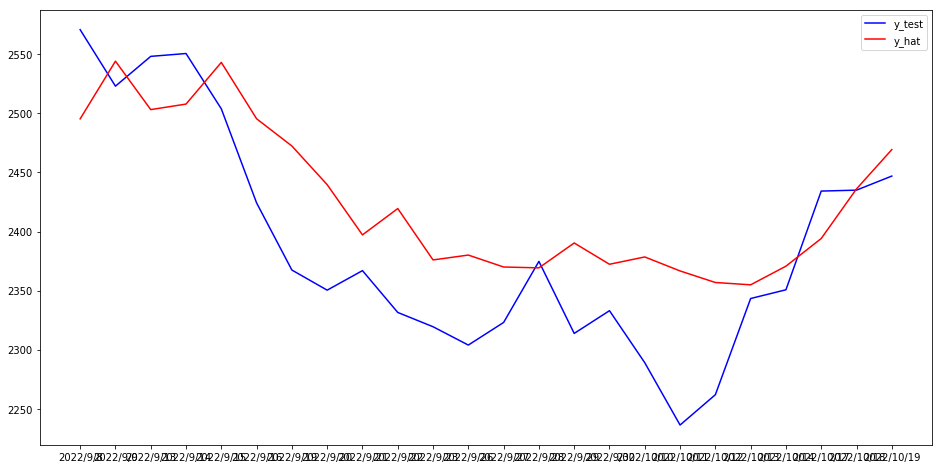

In [18]:
# 新建一个图像
plt.figure(figsize=(16,8))

lstm =lstm.cuda()
# lstm = torch.load('LSTM5.0')
lstm = torch.load('net.pkl')
lstm.eval()
# 预测结果
x_test, y_test, y_hat , mse, rmse, test_mse_sum, n = [], [], [], 0, 0, 0, 0
device = torch.device("cpu")
lstm = lstm.to(device)
for x, y in test_loader:
    x, y = x.to(device),y.to(device)
    y_pre = lstm(x)#.detach().cpu()
    y_test += y.tolist()
    y_hat += y_pre
    test_mse_sum += compute_mse(y_pre, y) * y.shape[0]
    n += y.shape[0]

# y_test = np.array(y_test)*(max_-min_) + min_
# y_hat = np.array(y_hat)*(max_-min_) + min_

for i in range(len(y_test)):
    y_test[i] = y_test[i][0]
y_test = np.array(y_test)*(max_-min_) + min_

for i in range(len(y_hat)):
    y_hat[i] = y_hat[i].item()
y_hat = np.array(y_hat)*(max_-min_) + min_

print(mean_squared_error(y_test,y_hat))
print(np.sqrt(mean_squared_error(y_test,y_hat)))
print(mean_absolute_error(y_test,y_hat))
print(r2_score(y_test,y_hat))
# 绘画某些结点第一天的情况
plt.plot(df.index[-24:],y_test[: ], c='blue', label='y_test')
plt.plot(df.index[-24:],y_hat[: ], c='red', label='y_hat')
# plt.plot(np.array(df.index[-417:]),y_test[: ], c='blue', label='y_test')
# plt.plot(np.array(df.index[-417:]),y_hat[: ], c='red', label='y_hat')

# 展示图像
plt.legend()

In [19]:
torch.save(lstm,'多特征end')